Goal: analyse sentiments with star ratings such that we can predict how happy someone is with a product from text alone

In [1]:
%matplotlib inline
datadir = "./data/"

import urllib.request, os, gzip

In [2]:
# Downloading a public dataset for Amazon reviews

def download_data(dataset_name, datadir):
    filename = "reviews_%s_5.json" % dataset_name
    filepath = os.path.join(datadir, filename)
    if os.path.exists(filepath):
        print("Dataset %s has already been downloaded to %s" % (dataset_name, datadir))
    else:
        url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/%s.gz" % filename
        urllib.request.urlretrieve(url, filepath + ".gz")
        with gzip.open(filepath + ".gz", "rb") as fin:
            with open(filepath, "wb") as fout:
                fout.write(fin.read())
        print("Downloaded dataset %s and saved it to %s" % (dataset_name, datadir))
        
dataset = "Pet_Supplies"
download_data(dataset, datadir)

Dataset Pet_Supplies has already been downloaded to ./data/


In [3]:
import json

# item_hash will be used later to partition data
# item converts JSON string to Python dict
# item["hash"] adds a hash for identification

def load_data(dataset_name, datadir):
    filepath = os.path.join(datadir, "reviews_%s_5.json" % dataset_name)
    if not os.path.exists(filepath):
        download_data(dataset_name, datadir)
    data = []
    with open(filepath, "r") as f:
        for line in f:
            item_hash = hash(line)
            item = json.loads(line)
            item["hash"] = item_hash
            data.append(item)
    print("Loaded %d data for dataset %s" % (len(data), dataset_name))
    return data

# Load data

pet_supplies = load_data(dataset, datadir)

# Look at example item
print(pet_supplies[9057])

Loaded 157836 data for dataset Pet_Supplies
{'reviewerID': 'AKGX64E7B6GSV', 'asin': 'B0002AQCXM', 'reviewerName': 'Frank Scarpelli', 'helpful': [0, 0], 'reviewText': 'Great for our Chameleon repti breeze, covers a good area for our pet to bask in the heat and move away when he has had enough.', 'overall': 5.0, 'summary': 'Does the Job.', 'unixReviewTime': 1372982400, 'reviewTime': '07 5, 2013', 'hash': -1676387978}


Dataset comment: 

The whole dataset contains 157836 items, with 9 fields called "reviewerID", "asin", "reviewerName", "helpful", "reviewText", "overall", "summary", "unixReviewTime", and "reviewTime". I also added a hash, which is a single number identifying the data item that is (extremely likely to be) unique. 

This particular data item was written on the 5th of July 2013 by the user Frank Scarpelli. Frank summarized the item as "does the job", and rated it 5 stars (out of 5). Nobody listed his review as helpful or unhelpful. 

Rule of thumb: use 60% of data as training set, 20% as validation set, and 20% as test set. 

The modulus of the hash is used to achieve good randomization of data between these sets. 

In [4]:
def partition_train_validation_test(data):
    # 60% of data, modulus 0 to 5
    data_train = [item for item in data if item["hash"]%10<=5]
    # 20% of data, modulus 6-7
    data_valid = [item for item in data if item["hash"]%10 in [6,7]]
    # 20% of data, modulus 8-9
    data_test = [item for item in data if item["hash"]%10 in [8,9]]
    return data_train, data_valid, data_test

pet_supplies_train, pet_supplies_valid, pet_supplies_test = partition_train_validation_test(pet_supplies)

print("Now there are", len(pet_supplies_train), "examples in the training set", len(pet_supplies_valid), "examples in the validation set, and", len(pet_supplies_test), "examples in the test set")

Now there are 94903 examples in the training set 31484 examples in the validation set, and 31449 examples in the test set


We need to preprocess the review text by extracting numeric features to feed into the predictor. For the simple baseline predictor, we will use two numeric features: frequency of positive words (fpos), and frequency of negative words (fneg). 

Hypothesis: reviews with high fpos are likely to get high star ratings; reviews with high fneg are likely to get low star ratings. fpos and fneg should be expressed as fractions to avoid bias from length of review. 

In [5]:
from nltk.corpus import opinion_lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

import random
random.seed(1234)
print("Some positive words:", ", ".join(random.sample(positive_words, 12)))
print("Some negative words:", ", ".join(random.sample(negative_words, 12)))

intersection = positive_words & negative_words
print("Words appearing in both sets:", ", ".join(intersection))

Some positive words: innovation, pep, jaw-dropping, astonished, patriotic, dominate, magnificent, fantastically, swankier, awsome, promptly, jubiliant
Some negative words: harden, brazenness, disrepute, intolerable, unthinkably, dissatisfactory, hoax, exile, nebulously, lethargic, violent, servitude
Words appearing in both sets: enviously, envious, enviousness


In [6]:
# Output number of positive and negative words respectively for a review, after removing stopwords

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
stopwords = set(stopwords.words("english"))

def my_tokenize(text):
    # tokenize text into lowercase tokens without punctuation and stopwords. any means that any token with a letter will be counted as a word
    tokens = []
    for sentence in sent_tokenize(text):
        tokens.extend(word for word in word_tokenize(sentence.lower())
                     if word not in stopwords and any(i.isalpha() for i in word))
    return tokens

def pos_neg_fraction(text):
    tokens = my_tokenize(text)
    count_pos, count_neg = 0, 0
    for t in tokens:
        if t in positive_words:
            count_pos += 1
        if t in negative_words:
            count_neg += 1
    # Avoid divide-by-zero for zero-length reviews
    count_all = len(tokens)
    if count_all != 0:
        return count_pos / count_all, count_neg / count_all
    else:
        return 0., 0.
    
pos_example = "This is a good, great, fantastic, amazing, wonderful, super product!"
neg_example = "This is a bad, atrocious, terrible, dreadful, awful, abysmal product!"
print(pos_neg_fraction(pos_example))
print(pos_neg_fraction(neg_example))

(0.8571428571428571, 0.0)
(0.0, 0.8571428571428571)


Make sure you only use the training set for now! 

Convert the training set to a matrix "X-train" with two columns, for positive fraction and negative fraction. 

Represent matrices using numpy.array. 

In [7]:
import numpy

def dataset_to_matrix(data):
    return numpy.array([list(pos_neg_fraction(item["reviewText"])) for item in data])

X_train = dataset_to_matrix(pet_supplies_train)
most_pos, most_neg = numpy.argmax(X_train, axis = 0)

print("Highest fraction of positive words: %f %% positive words for example %d" % (100.*X_train[most_pos, 0], most_pos))
print(pet_supplies_train[most_pos])
print("Highest fraction of negative words: %f %% negative words for example %d" % (100.*X_train[most_neg, 1], most_neg))
print(pet_supplies_train[most_neg])

Highest fraction of positive words: 100.000000 % positive words for example 79
{'reviewerID': 'A1K9SIFW86UAT8', 'asin': 'B00005MF9W', 'reviewerName': 'Laura Seche "loll"', 'helpful': [0, 0], 'reviewText': 'Great', 'overall': 5.0, 'summary': 'Five Stars', 'unixReviewTime': 1404864000, 'reviewTime': '07 9, 2014', 'hash': 1705898670}
Highest fraction of negative words: 100.000000 % negative words for example 14242
{'reviewerID': 'A3CLETWGOTGTSB', 'asin': 'B0002XUJFG', 'reviewerName': 'Melissa', 'helpful': [0, 0], 'reviewText': 'Leaks', 'overall': 2.0, 'summary': 'Two Stars', 'unixReviewTime': 1403740800, 'reviewTime': '06 26, 2014', 'hash': -1033962400}


X_train is the feature matrix (known data) and Y_train is the target vector (what we want to predict). 

The field "overall" is used by Amazon for the star ratings.

In [8]:
def dataset_to_targets(data):
    return numpy.array([item["overall"] for item in data])

Y_train = dataset_to_targets(pet_supplies_train)
print("The two-dimensional feature matrix has shape", X_train.shape)
print("The one-dimensional target matrix has shape", Y_train.shape)

The two-dimensional feature matrix has shape (94903, 2)
The one-dimensional target matrix has shape (94903,)


For a real machine learning project you should now explore and visualize the data more to get a feeling for how features and targets are distributed to identify techniques that are a good fit for the problem. 

Take a look at the Pandas library to learn more... 

For now, we will visualize the number of each star ratings: 

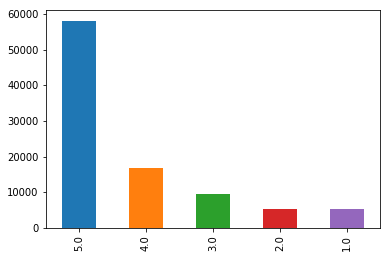

In [9]:
import pandas
pandas.Series(Y_train).value_counts().plot.bar()

The data are biased towards 5-star ratings, which seems to be common. 

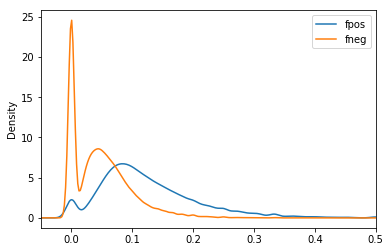

In [10]:
df = pandas.DataFrame(data = X_train, columns = ["fpos", "fneg"])
df.plot.kde(xlim = (-0.05, 0.5))

Most reviews contain 0 negative words! 

# Predictor

We are using a linear regression model. Later we will use TEnsorflow to train a linear regression model. For now we will use Scikit-learn, which has good implementaions of classical predictors including linear regression. 

In [32]:
from sklearn.linear_model import LinearRegression
lreg = LinearRegression().fit(X_train, Y_train)

print("The fpos coefficient is", lreg.coef_[0])
print("The fneg coefficient is", lreg.coef_[1])
print("The intercept is", lreg.intercept_)

The fpos coefficient is 3.1870977382486507
The fneg coefficient is -3.466346126246286
The intercept is 3.999534520466239


This is a simple linear regression model. The intercept shows that when fpos and fneg are 0, the review will get 4* on average. 

Test: if we have no positive words and a 20% negative word content, we expect the following rating:

In [12]:
features = [[0, 0.2]]
expected_rating_A = lreg.predict(features)[0]
print("Expected rating: %f stars" % expected_rating_A)

Expected rating: 3.306265 stars


# Homework

And repeat this for 'apps for Android' section

In [13]:
# Expectation for 100% positive words

features = [[1, 0]]
expected_rating_A = lreg.predict(features)[0]
print("Expected rating: %f stars" % expected_rating_A)

Expected rating: 7.186632 stars


In [14]:
# Expectation for 100% negative words

features = [[0, 1]]
expected_rating_A = lreg.predict(features)[0]
print("Expected rating: %f stars" % expected_rating_A)

Expected rating: 0.533188 stars


That's pretty intense! We should cut off impossible results by setting expectations to between 1* and 5*. 

In [15]:
def predict_lreg(features):
    expected_rating = lreg.predict(features)
    expected_rating[expected_rating > 5.0] = 5.0
    expected_rating[expected_rating < 1.0] = 1.0
    return expected_rating

pred_train = predict_lreg(X_train)

In [16]:
def analyse_training_example(i):
    print("Training example number", i)
    print("True rating = %f stars, expectation = %f stars" % (Y_train[i], pred_train[i]))
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % pet_supplies_train[i]["reviewText"])
    
for i in [0, 10000, 20000, 3000, 5000]:
    analyse_training_example(i)
    print("")

Training example number 0
True rating = 3.000000 stars, expectation = 4.119043 stars
Features = 0.058824 / 0.019608
Review text = I purchased the Trilogy with hoping my two cats, age 3 and 5 would be interested.  The 3 yr old cat was fascinated for about 15 minutes but when the same pictures came on, she got bored.  The 5 year old watched for about a few minutes but then walked away. It is possible that because we have a wonderful courtyard full of greenery and trees and one of my neighbors has a bird feeder, that there is enough going on outside that they prefer real life versus a taped version.  I will more than likely pass this on to a friend who has cats that don't have as much wildlife to watch as mine do.

Training example number 10000
True rating = 5.000000 stars, expectation = 4.381986 stars
Features = 0.120000 / 0.000000
Review text = Purchased this because our cat keeps destroying the feather toys we attach to our current wand. The fleece piece is a perfect weight and length 

In [133]:
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(pred_train, Y_train)
print("The mean absolute error in the training data is %f stars" % mae_train)

The mean absolute error in the training data is 0.875199 stars


# Apps for Android prediction

In [18]:
# Downloading a public dataset for Amazon reviews

def download_data(dataset_name, datadir):
    filename = "reviews_%s_5.json" % dataset_name
    filepath = os.path.join(datadir, filename)
    if os.path.exists(filepath):
        print("Dataset %s has already been downloaded to %s" % (dataset_name, datadir))
    else:
        url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/%s.gz" % filename
        urllib.request.urlretrieve(url, filepath + ".gz")
        with gzip.open(filepath + ".gz", "rb") as fin:
            with open(filepath, "wb") as fout:
                fout.write(fin.read())
        print("Downloaded dataset %s and saved it to %s" % (dataset_name, datadir))
        
dataset2 = "Apps_for_Android"
download_data(dataset2, datadir)

Dataset Apps_for_Android has already been downloaded to ./data/


In [19]:
# Load data
apps_for_android = load_data(dataset2, datadir)

# Look at example item
print(apps_for_android[9057])

Loaded 752937 data for dataset Apps_for_Android
{'reviewerID': 'A23IYYG2YBSDQZ', 'asin': 'B004GYY714', 'reviewerName': 'gshsue', 'helpful': [0, 1], 'reviewText': 'its ok but it just is hard to find stations on it and it doesnt have all the stations and its annoying and stupid', 'overall': 2.0, 'summary': 'ok', 'unixReviewTime': 1329609600, 'reviewTime': '02 19, 2012', 'hash': 1022074374}


In [20]:
apps_train, apps_valid, apps_test = partition_train_validation_test(apps_for_android)

print("Now there are", len(apps_train), "examples in the training set", len(apps_valid), "examples in the validation set, and", len(apps_test), "examples in the test set")

Now there are 451999 examples in the training set 150416 examples in the validation set, and 150522 examples in the test set


In [21]:
X_train_apps = dataset_to_matrix(apps_train)
Y_train_apps = dataset_to_targets(apps_train)

lreg_apps = LinearRegression().fit(X_train_apps, Y_train_apps)

print("The fpos coefficient is", lreg_apps.coef_[0])
print("The fneg coefficient is", lreg_apps.coef_[1])
print("The intercept is", lreg_apps.intercept_)

The fpos coefficient is 3.7916154619931883
The fneg coefficient is -3.939633395263729
The intercept is 3.5432997477946007


In [22]:
# 100% positive words - expected rating for Android app reviews

features = [[1, 0]]
expected_rating_A = lreg_apps.predict(features)[0]
print("Expected rating: %f stars" % expected_rating_A)

Expected rating: 7.334915 stars


In [23]:
# 100% negative words - expected rating for Android app reviews

features = [[0, 1]]
expected_rating_A = lreg_apps.predict(features)[0]
print("Expected rating: %f stars" % expected_rating_A)

Expected rating: -0.396334 stars


# Day 2
# Classification (not regression)

Trying to get a simple binary result (is an email spam or not?). 
Figure out a variable D_train, where if the customer is dissatisfied, D_train is true. 

In [25]:
def discretize_targets(Y):
    return Y<=3.0

D_train = discretize_targets(Y_train)
print("The training data contain %f%% dissatisfied customers" % (100.*D_train.mean()))
print(D_train[:12])

The training data contain 21.170037% dissatisfied customers
[ True False  True False False False False  True  True False False  True]


False positive = review wrongly flagged as negative
False negative = negative review wrongly let past

Often the algorithm is just used to flag reviews for manual checking. 

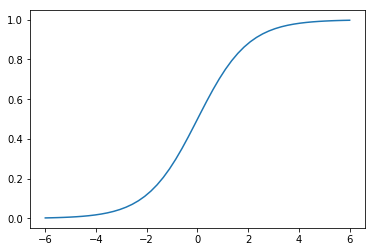

In [27]:
points = numpy.linspace(-6.0, 6.0)
logistic_function = pandas.Series(1/(numpy.exp(-points)+1), index=points)
logistic_function.plot()

predict)proba() produces a two-column matrix. First column contains probability for D_train being false; second for D_train being true. 

The second column is selected with [:,1]. 
(The second row would be selected with [1,:]. 

In [43]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().fit(X_train, D_train)

prob2_train = logreg.predict_proba(X_train)[:,1]
pred2_train = prob2_train > 0.5

# If probability negative is > 0.5 we will flag it as a dissatisfied review

max_prob2 = numpy.argmax(prob2_train)
min_prob2 = numpy.argmin(prob2_train)

def analyse_training_example_2(i):
    print("Training example number", i)
    print("True rating = %f stars" % Y_train[i])
    print("Expected to be dissatisfied:", pred2_train[i])
    print("Expected probability of being dissatisfied : %f" % prob2_train[i])
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % apps_train[i]['reviewText'])
    
analyse_training_example_2(min_prob2)

Training example number 79
True rating = 5.000000 stars
Expected to be dissatisfied: False
Expected probability of being dissatisfied : 0.000070
Features = 1.000000 / 0.000000
Review text = I love waking up each day to a bible verse.  You have the opportunity to save verses creating a type of "favorite list.". You can look up verses in full context and in different Bible versions.  There are other features, and the app works great on any phone I've ever had.


In [44]:
analyse_training_example_2(max_prob2)

Training example number 14242
True rating = 2.000000 stars
Expected to be dissatisfied: True
Expected probability of being dissatisfied : 0.992437
Features = 0.000000 / 1.000000
Review text = Enjoy Sudoku Daily  by Jason Linhart works better than the newspaper versions. I especially like the way the hint works in two stages when I am stuck.


In [47]:
analyse_training_example_2(1009)

Training example number 1009
True rating = 1.000000 stars
Expected to be dissatisfied: False
Expected probability of being dissatisfied : 0.383099
Features = 0.034803 / 0.083527
Review text = I've used Kindle for books and magazines and it is, to me, a preferred system.very easy to use. It also has a quick connection to the store to make purchases.Guess I can't say enough about Kindle. It is an excellent reader.


Conclusion: people sometimes fail to understand the pretty simple concept of star ratings. 

Precision is % relevant instances among retrieved instances. ie: % of true positives among all positives
Sensitivity is % relevant instances that were retrieved out of total relevant instances. ie: % true positives out of (true positives + false negatives)

Sensitivity is also known as "recall"

In [48]:
from sklearn.metrics import precision_score, recall_score
precision2 = precision_score(D_train, pred2_train)
recall2 = recall_score(D_train, pred2_train)
print("For threshold 0.5, we get precision %f "
     "and recall %f" % (precision2, recall2))

For threshold 0.5, we get precision 0.586075 and recall 0.038127


We only found 4% of the dissatisfied people...

# Homework

In [50]:
# Change the threshold for negative reviews to 0.2 and rerun

pred2_train = prob2_train > 0.2

precision2 = precision_score(D_train, pred2_train)
recall2 = recall_score(D_train, pred2_train)

print("For threshold 0.2, we get precision %f "
     "and recall %f" % (precision2, recall2))

For threshold 0.2, we get precision 0.297674 and recall 0.730028


We found 73% of the dissatisfied people!

Precision as function of threshold: 


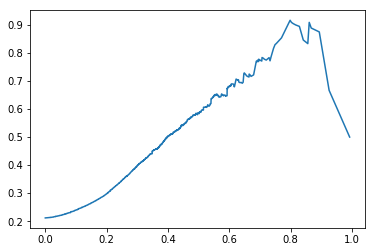

In [57]:
from sklearn.metrics import precision_recall_curve
all_precision2, all_recall2, all_thresh2 = precision_recall_curve(
    D_train, prob2_train)
print("Precision as function of threshold: ")
pandas.Series(all_precision2[:-1], index = all_thresh2).plot()

Recall as function of threshold: 


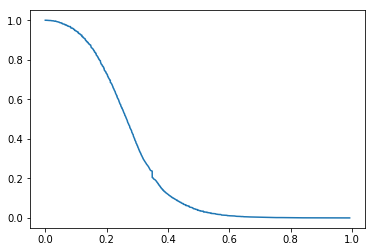

In [59]:
print("Recall as function of threshold: ")
pandas.Series(all_recall2[:-1], index = all_thresh2).plot()

With the new model, precision is 0.428472 and recall is 0.092131


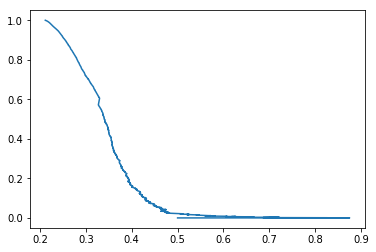

In [65]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
nb = GaussianNB().fit(X_train, D_train)
prob3_train = nb.predict_proba(X_train)[:,1]
pred3_train = prob3_train > 0.5
precision3 = precision_score(D_train, pred3_train)
recall3 = recall_score(D_train, pred3_train)
print("With the new model, precision is %f and recall is %f" % (precision3, recall3))
all_precision3, all_recall3, all_thresh3 = precision_recall_curve(D_train, prob3_train)

pandas.Series(all_recall3[:-1], index = all_precision3[:-1]).plot()

At the 0.5 threshold, it's not much better than earlier. This is an underlying feature of the dataset. Ideally, we'd like the curve to look like the upper right quadrant arc of a circle.

# TensorFlow
Linear regression
Okay this bit isn't going to work for me so I'ma skip it

# NLTK built-in sentiment analyser

In [84]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import mark_negation
examples_negation = ["This product wasn't bad.",
                     "This is not a bad product.",
                     "This product was bad.",
                     "This is a bad product."]

for sentence in examples_negation:
    tokens_with_negation = mark_negation(word_tokenize(sentence.lower()))
    print("Sentence =", sentence)
    print(tokens_with_negation)

negated_stopwords = set(word + "_NEG" for word in eng_stopwords)
all_stopwords = eng_stopwords.union(negated_stopwords)
    
def tokenize_with_negation(text):
    # split text into lower-case tokens, removing all-punctuation tokens and stopwords
    tokens = []
    for sentence in sent_tokenize(text):
        pretokens = word_tokenize(sentence.lower())
        pretokens = [x for x in pretokens if any(i.isalpha() for i in x)]
        pretokens = mark_negation(pretokens)
        tokens.extend(x for x in pretokens if x not in all_stopwords)
    return tokens

print(apps_train[31]['reviewText'])
print(tokenize_with_negation(apps_train[31]['reviewText']))

Sentence = This product wasn't bad.
['this', 'product', 'was', "n't", 'bad_NEG', '.']
Sentence = This is not a bad product.
['this', 'is', 'not', 'a_NEG', 'bad_NEG', 'product_NEG', '.']
Sentence = This product was bad.
['this', 'product', 'was', 'bad', '.']
Sentence = This is a bad product.
['this', 'is', 'a', 'bad', 'product', '.']
No matter what kind of music I want to listen to, its there! I even get a guided meditations anytime I want! Its unlimited!
['matter_NEG', 'kind_NEG', 'music_NEG', 'want_NEG', 'listen_NEG', 'even', 'get', 'guided', 'meditations', 'anytime', 'want', 'unlimited']


In [86]:
all_pos_words = positive_words.union({x + "_NEG" for x in negative_words})
all_neg_words = negative_words.union({x + "_NEG" for x in positive_words})

def pos_neg_fraction_with_negation(text):
    tokens = tokenize_with_negation(text)
    count_pos, count_neg = 0, 0
    for t in tokens:
        if t in all_pos_words:
            count_pos += 1
        if t in all_neg_words:
            count_neg += 1
    count_all = len(tokens)
    if count_all != 0:
        return count_pos/count_all, count_neg/count_all
    else:
        return 0., 0.

print(pos_neg_fraction_with_negation(pos_example))
print(pos_neg_fraction_with_negation(neg_example))

(0.8571428571428571, 0.0)
(0.0, 0.8571428571428571)


In [87]:
pos_example_neg = "This is not a good, great, fantastic, amazing, wonderful, super app!!!"
neg_example_neg = "This is not a bad, atrocious, terrible, dreadful, awful, abysmal app!!!"

print(pos_neg_fraction_with_negation(pos_example_neg))
print(pos_neg_fraction_with_negation(neg_example_neg))

(0.0, 0.8571428571428571)
(0.8571428571428571, 0.0)


In [95]:
def dataset_to_matrix_with_neg(data):
    return numpy.array([list(pos_neg_fraction_with_negation(item["reviewText"])) for item in data])

X_train_neg = dataset_to_matrix_with_neg(pet_supplies_train)

lreg_neg = LinearRegression().fit(X_train_neg, Y_train)
pred_train_neg = lreg_neg.predict(X_train_neg)
mae_train_with_neg = mean_absolute_error(pred_train_neg, Y_train)
print("Now the mean absolute error on the training data is %f stars" % mae_train_with_neg)

Now the mean absolute error on the training data is 0.862884 stars


# Random forest
Woop woop

In [97]:
from sklearn.ensemble import RandomForestRegressor
rf_neg = RandomForestRegressor().fit(X_train_neg, Y_train)
pred_train_rf_neg = rf_neg.predict(X_train_neg)
mae_train_rf_neg = mean_absolute_error(pred_train_rf_neg, Y_train)

print("A non-linear regressor achieves a MAE of %f stars" % mae_train_rf_neg)

A non-linear regressor achieves a MAE of 0.767418 stars


# Short-List Promising Models
Notes:

If the data is huge, you may want to sample smaller training sets so you can train many different models in a reasonable time (be aware that this penalizes complex models such as large neural nets or Random Forests). Once again, try to automate these steps as much as possible.

Train many quick and dirty models from different categories (e.g., linear, naive Bayes, SVM, Random Forests, neural net, etc.) using standard parameters.
Measure and compare their performance. For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds.
Analyze the most significant variables for each algorithm.
Analyze the types of errors the models make. What data would a human have used to avoid these errors?
Have a quick round of feature selection and engineering.
Have one or two more quick iterations of the five previous steps.
Short-list the top three to five most promising models, preferring models that make different types of errors.

# Day 3

In [107]:
print(pet_supplies_train[65000]["reviewText"])

This just arrived today and a huge hit but with a caveat...This 2nd version, made of sturdy foam, replaces an earlier version that I believe was made of wood. I would like to add my 2 cents after watching my cats have a ball with this new toy today...I would encourage the company to replace the foam mice with plastic to avoid claws getting stuck in the mice.One of my cats is big & plays rough -  as she did/is doing with this toy. Several times since it's arrival today, she's managed to get a toe claw stuck in one of the mice & because the house is lightweight she had difficulty getting her claw unstuck so the house moved with her & twisted her toe. Once unstuck, she licked her toe for a few minutes so I assume she hurt herself in the process of getting unstuck. Not good, but didn't stop her from going back for more! It's a huge hit other than the foam mice!Some will say clip her claws, but we've never had to do that as have scratching trees & posts all over the house & in 4 years since

In [135]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
text = pet_supplies_train[65000]["reviewText"]
for s in sent_tokenize(text):
    print(s)
    print(sia.polarity_scores(s))
    print("")

This just arrived today and a huge hit but with a caveat...This 2nd version, made of sturdy foam, replaces an earlier version that I believe was made of wood.
{'neg': 0.0, 'neu': 0.938, 'pos': 0.062, 'compound': 0.1655}

I would like to add my 2 cents after watching my cats have a ball with this new toy today...I would encourage the company to replace the foam mice with plastic to avoid claws getting stuck in the mice.One of my cats is big & plays rough -  as she did/is doing with this toy.
{'neg': 0.074, 'neu': 0.789, 'pos': 0.137, 'compound': 0.5574}

Several times since it's arrival today, she's managed to get a toe claw stuck in one of the mice & because the house is lightweight she had difficulty getting her claw unstuck so the house moved with her & twisted her toe.
{'neg': 0.106, 'neu': 0.894, 'pos': 0.0, 'compound': -0.5267}

Once unstuck, she licked her toe for a few minutes so I assume she hurt herself in the process of getting unstuck.
{'neg': 0.162, 'neu': 0.838, 'pos': 0.0

For each review text, extract: 
1) mean positive sentiment over all sentences
2) mean netural sentiment OAS
3) mean negative sentiment OAS
4) maximum positive sentiment OAS
5) maximum neutral sentiment OAS
6) maximum negative sentiment OAS

In [114]:
def sia_features(dataset):
    feat_matrix = numpy.empty((len(dataset), 6))
    for i in range(len(dataset)):
        sentences = sent_tokenize(dataset[i]["reviewText"])
        nsent = len(sentences)
        if nsent:
            sentence_polarities = numpy.empty((nsent, 3))
            for j in range(nsent):
                polarity = sia.polarity_scores(sentences[j])
                sentence_polarities[j, 0] = polarity["pos"]
                sentence_polarities[j, 1] = polarity["neu"]
                sentence_polarities[j, 2] = polarity["neg"]
            feat_matrix[i, 0:3] = numpy.mean(sentence_polarities, axis = 0)   # mean over the columns
            feat_matrix[i, 3:6] = numpy.max(sentence_polarities, axis = 0)   # max over the columns
        else: 
            feat_matrix[i, 0:6] = 0.
    return feat_matrix

sia_tr = sia_features(pet_supplies_train)

The 'if' clause above is necessary to avoid zero-length reviews

In [116]:
testmat = numpy.arange(12.).reshape((3, 4))
print(testmat)
print(numpy.max(testmat, axis = 0))
print(numpy.mean(testmat, axis = 1))

[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]]
[ 8.  9. 10. 11.]
[1.5 5.5 9.5]


In [117]:
# Add review length (truncate to 2500 characters)
# Add % of exclamation marks for sentiment intensity

def len_features(dataset):
    feat_matrix = numpy.empty((len(dataset), 2))
    for i in range(len(dataset)):
        text = dataset[i]["reviewText"]
        feat_matrix[i, 0] = len(text) / 1000.
        if text:
            feat_matrix[i, 1] = 100. * text.count("!") / len(text)
        else:
            feat_matrix[i, 1] = 0.
    feat_matrix[feat_matrix > 2.5] = 2.5
    return feat_matrix

len_tr = len_features(pet_supplies_train)

print(X_train_neg.shape, sia_tr.shape, len_tr.shape)

(94903, 2) (94903, 6) (94903, 2)


In [118]:
X_train_augmented = numpy.concatenate((X_train_neg, sia_tr, len_tr), axis = 1) #stack horizontally
lreg_augmented = LinearRegression().fit(X_train_augmented, Y_train)
pred_train_augmented = lreg_augmented.predict(X_train_augmented)
mae_train_augmented = mean_absolute_error(pred_train_augmented, Y_train)
print("Now the MAE on the training data is %f stars" % mae_train_augmented)

Now the MAE on the training data is 0.811463 stars


In [122]:
rf_augmented = RandomForestRegressor().fit(X_train_augmented, Y_train)
rfpred_train_augmented = rf_augmented.predict(X_train_augmented)
mae_train_rf_augmented = mean_absolute_error(rfpred_train_augmented, Y_train)
print("For the random forest, the MAE on the training data is %f stars" % mae_train_rf_augmented)

For the random forest, the MAE on the training data is 0.309887 stars


In [129]:
X_valid_neg = dataset_to_matrix_with_neg(pet_supplies_valid)
sia_valid = sia_features(pet_supplies_valid)
len_valid = len_features(pet_supplies_valid)
X_valid_augmented = numpy.concatenate((X_valid_neg, sia_valid, len_valid), axis = 1)
pred_valid_augmented = lreg_augmented.predict(X_valid_augmented)
pred_valid_rf_augmented = rf_augmented.predict(X_valid_augmented)

print("done")

done


In [136]:
Y_valid = dataset_to_targets(pet_supplies_valid)

print("done")

done


In [132]:
mae_valid_augmented = mean_absolute_error(pred_valid_augmented, Y_valid)
print("On the validation set, we get %f error for the linear regression" % mae_valid_augmented)

mae_valid_rf_augmented = mean_absolute_error(pred_valid_rf_augmented, Y_valid)
print("And %f for the random forest regression" % mae_valid_rf_augmented)

On the validation set, we get 0.809588 error for the linear regression
And 0.802078 for the random forest regression


# Homework - refactoring

# Single function for all success metrics

In [153]:
# def mae_method(augmented_data):
#     return mean_absolute_error(augmented_data, Y_train)

# def mae_valid(augmented_data):
#     return mean_absolute_error(augmented_data, Y_valid)

# X_train_augmented = numpy.concatenate((X_train_neg, sia_tr, len_tr), axis = 1) #stack horizontally
# lreg_augmented = LinearRegression().fit(X_train_augmented, Y_train)
# pred_train_augmented = lreg_augmented.predict(X_train_augmented)
# mae_train_augmented = mae_method(pred_train_augmented)
# print("Now the MAE on the training data is %f stars" % mae_train_augmented)

Now the MAE on the training data is 0.811463 stars


In [148]:
# rf_augmented = RandomForestRegressor().fit(X_train_augmented, Y_train)
# rfpred_train_augmented = rf_augmented.predict(X_train_augmented)
# mae_train_rf_augmented = mae_method(rfpred_train_augmented)
# print("For the random forest, the MAE on the training data is %f stars" % mae_train_rf_augmented)

For the random forest, the MAE on the training data is 0.309610 stars


In [161]:
# def lr_metrics(dataset, Y_dataset):
#     sia_dataset = sia_features(dataset)
#     len_dataset = len_features(dataset)
#     X_dataset_neg = dataset_to_matrix_with_neg(dataset)
    
#     X_dataset_aug = numpy.concatenate((X_dataset_neg, sia_dataset, len_dataset), axis = 1)
#     lreg_dataset_aug = LinearRegression().fit(X_dataset_aug, Y_dataset)
#     pred_dataset_aug = lreg_dataset_aug.predict(X_dataset_aug)
    
#     mae_lr = mean_absolute_error(pred_dataset_aug, Y_dataset)
    
#     return mae_lr

# train_lr_metrics = lr_metrics(pet_supplies_train, Y_train)
# valid_lr_metrics = lr_metrics(pet_supplies_valid, Y_valid)

# print("Now the MAE on the training data is %f stars" % train_lr_metrics)
# print("On the validation set, we get %f stars' error for the linear regression" % valid_lr_metrics)

Now the MAE on the training data is 0.811463 stars
On the validation set, we get 0.808628 stars' error for the linear regression


In [173]:
def metrics(dataset):
    sia_dataset = sia_features(dataset)
    len_dataset = len_features(dataset)
    X_dataset_neg = dataset_to_matrix_with_neg(dataset)
    Y_dataset = dataset_to_targets(dataset)
    
    X_dataset_aug = numpy.concatenate((X_dataset_neg, sia_dataset, len_dataset), axis = 1)
    lreg_dataset_aug = LinearRegression().fit(X_dataset_aug, Y_dataset)
    pred_dataset_aug = lreg_dataset_aug.predict(X_dataset_aug)
    
    mae_lr = mean_absolute_error(pred_dataset_aug, Y_dataset)
    
    rf_dataset_aug = RandomForestRegressor().fit(X_dataset_aug, Y_dataset)
    pred_dataset_rf_aug = rf_dataset_aug.predict(X_dataset_aug)
    
    mae_rf = mean_absolute_error(pred_dataset_rf_aug, Y_dataset)
    
    return mae_lr, mae_rf

train_lr_metrics = metrics(pet_supplies_train)[0]
train_rf_metrics = metrics(pet_supplies_train)[1]

valid_lr_metrics = metrics(pet_supplies_valid)[0]
valid_rf_metrics = metrics(pet_supplies_valid)[1]

print("Now the MAE on the training data is %f stars" % train_lr_metrics)
print("On the validation set, we get %f stars' error for the linear regression" % valid_lr_metrics)
print("")
print("On the validation set, we get %f error for the linear regression" % mae_valid_augmented)
print("And %f for the random forest regression" % mae_valid_rf_augmented)

Now the MAE on the training data is 0.811463 stars
On the validation set, we get 0.808628 stars' error for the linear regression

On the validation set, we get 0.809588 error for the linear regression
And 0.801529 for the random forest regression
